In [26]:
%load_ext autoreload
%autoreload 2

import sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt
import torch

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
sys.path.append(os.path.join(os.getcwd(), '..'))
from symlie.misc.utils import NumpyUtils, Results, tensor_operation, numpy_operation, Args
from symlie.misc.viz import plot2d
from symlie.model.setup import find_id_for_P, load_P_pred
from symlie.model.networks.linear import CalculatedP
from symlie.misc.viz import plot2d
from symlie.data.generate_2d import sine1d, sine2d, flower, mnist
from symlie.data.generate_data import datasets
from symlie.data.dataset import FlatDataset

from symlie.misc.utils_results import plot_data, assert_unique, pivot, plot_pivot, add_df_map_new, assert_columns_same, get_and_check_Ps, plot_seeds_and_Ps, rename_net, stringify_dict
from symlie.misc.wandb import exceptions, new_runs, update_results_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
update_results_df()

df = pd.read_pickle('../logs/store/results_df.pkl')
print(df.shape)
print(df.columns)
df.head()

37


Retreiving wandb 0e5ih43j: 100%|██████████| 37/37 [00:08<00:00,  4.28it/s]

(564, 44)
Index(['lr', 'net', 'bias', 'name', 'seed', 'tags', 'test', 'n_val', 'train',
       'y_low', 'device', 'logger', 'n_test', 'run_id', 'y_high', 'log_dir',
       'n_train', 'predict', 'version', 'data_dir', 'eps_mult', 'n_splits',
       'criterion', 'do_return', 'earlystop', 'grid_size', 'noise_std',
       'only_flip', 'batch_size', 'max_epochs', 'data_kwargs', 'num_workers',
       'generate_data', 'model_summary', 'args_processed', 'do_return_model',
       'transform_kwargs', 'persistent_workers', 'run_name', 'test_loss',
       'out_features', 'A_low', 'A_high', 'config'],
      dtype='object')


,lr,net,bias,name,seed,tags,test,n_val,train,y_low,...,args_processed,do_return_model,transform_kwargs,persistent_workers,run_name,test_loss,out_features,A_low,A_high,config
0,0.001,TrainP,False,None,2,"[mnist, new]",True,1000,True,NaN,...,True,False,"{'eps_mult': [0, 1, 1, 1], 'only_flip': False}",True,red-dumpling-886,0.006070,NaN,NaN,NaN,NaN
1,0.010,TrainP,False,None,1,"[mnist, new]",True,1000,True,NaN,...,True,False,"{'eps_mult': [0, 1, 1, 1], 'only_flip': False}",True,beaming-firecracker-878,0.003705,NaN,NaN,NaN,NaN
2,0.100,TrainP,False,None,1,"[mnist, new]",True,1000,True,NaN,...,True,False,"{'eps_mult': [0, 1, 1, 1], 'only_flip': False}",True,lunar-envelope-879,0.003931,NaN,NaN,NaN,NaN
3,0.100,TrainP,False,None,2,"[mnist, new]",True,1000,True,NaN,...,True,False,"{'eps_mult': [0, 1, 1, 1], 'only_flip': False}",True,dancing-bao-873,0.004032,NaN,NaN,NaN,NaN
4,0.001,TrainP,False,None,1,"[mnist, new]",True,1000,True,NaN,...,True,False,"{'eps_mult': [0, 1, 1, 1], 'only_flip': False}",True,glittering-noodles-872,0.005908,NaN,NaN,NaN,NaN


In [31]:
df['tags']

0                         ['mnist', 'new']
1                         ['mnist', 'new']
2                         ['mnist', 'new']
3                         ['mnist', 'new']
4                         ['mnist', 'new']
                      ...                 
559    ['new', 'sine1dtwo-hparam-predict']
560    ['new', 'sine1dtwo-hparam-predict']
561    ['new', 'sine1dtwo-hparam-predict']
562    ['new', 'sine1dtwo-hparam-predict']
563    ['new', 'sine1dtwo-hparam-predict']
Name: tags, Length: 564, dtype: object

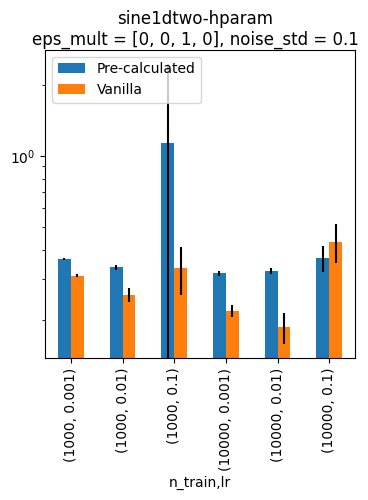

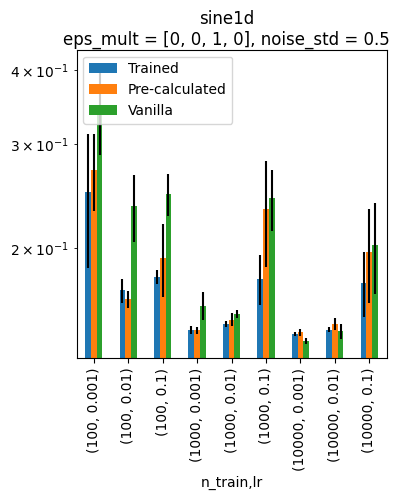

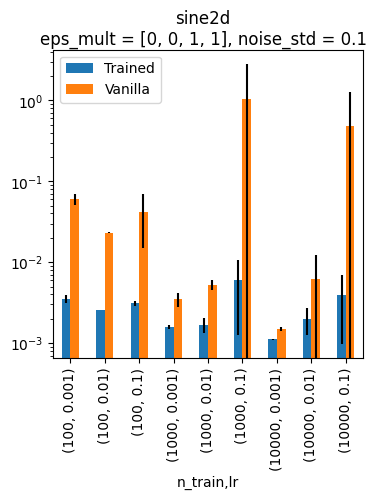

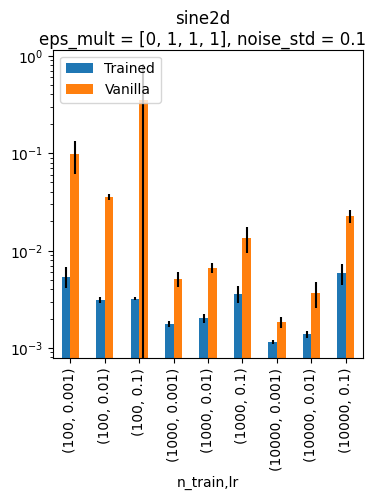

test_loss  \
n_train                                                 1000   
lr                                                     0.001   
net                                           Pre-calculated   
dataset_name     eps_mult     noise_std                        
sine1dtwo-hparam [0, 0, 1, 0] 0.1        3.63e-01 ± 3.69e-03   
sine1d           [0, 0, 1, 0] 0.5        1.45e-01 ± 1.92e-03   
sine2d           [0, 0, 1, 1] 0.1                        NaN   
                 [0, 1, 1, 1] 0.1                        NaN   

                                                              \
n_train                                                        
lr                                                             
net                                                  Vanilla   
dataset_name     eps_mult     noise_std                        
sine1dtwo-hparam [0, 0, 1, 0] 0.1        3.10e-01 ± 4.20e-03   
sine1d           [0, 0, 1, 0] 0.5        1.60e-01 ± 8.71e-03   
sine2d           [0, 0, 1, 1] 0.1        3.48e-03 ± 7.06e-04   
                 [0, 1, 1, 1] 0.1        5.12e-03 ± 9.03e-04   

                                                              \
n_train                                                        
lr                                                      0.01   
net                                           Pre-calculated   
dataset_name     eps_mult     noise_std                        
sine1dtwo-hparam [0, 0, 1, 0] 0.1        3.36e-01 ± 8.30e-03   
sine1d           [0, 0, 1, 0] 0.5        1.51e-01 ± 3.80e-03   
sine2d           [0, 0, 1, 1] 0.1                        NaN   
                 [0, 1, 1, 1] 0.1                        NaN   

                                                              \
n_train                                                        
lr                                                             
net                                                  Vanilla   
dataset_name     eps_mult     noise_std                        
sine1dtwo-hparam [0, 0, 1, 0] 0.1        2.57e-01 ± 1.84e-02   
sine1d           [0, 0, 1, 0] 0.5        1.55e-01 ± 2.29e-03   
sine2d           [0, 0, 1, 1] 0.1        5.26e-03 ± 7.66e-04   
                 [0, 1, 1, 1] 0.1        6.67e-03 ± 8.30e-04   

                                                              \
n_train                                                        
lr                                                       0.1   
net                                           Pre-calculated   
dataset_name     eps_mult     noise_std                        
sine1dtwo-hparam [0, 0, 1, 0] 0.1        1.14e+00 ± 1.32e+00   
sine1d           [0, 0, 1, 0] 0.5        2.33e-01 ± 4.73e-02   
sine2d           [0, 0, 1, 1] 0.1                        NaN   
                 [0, 1, 1, 1] 0.1                        NaN   

                                                              \
n_train                                                        
lr                                                             
net                                                  Vanilla   
dataset_name     eps_mult     noise_std                        
sine1dtwo-hparam [0, 0, 1, 0] 0.1        3.33e-01 ± 7.63e-02   
sine1d           [0, 0, 1, 0] 0.5        2.42e-01 ± 2.89e-02   
sine2d           [0, 0, 1, 1] 0.1        1.05e+00 ± 1.80e+00   
                 [0, 1, 1, 1] 0.1        1.34e-02 ± 4.08e-03   

                                                              \
n_train                                                10000   
lr                                                     0.001   
net                                           Pre-calculated   
dataset_name     eps_mult     noise_std                        
sine1dtwo-hparam [0, 0, 1, 0] 0.1        3.17e-01 ± 7.42e-03   
sine1d           [0, 0, 1, 0] 0.5        1.44e-01 ± 2.05e-03   
sine2d           [0, 0, 1, 1] 0.1                        NaN   
                 [0, 1, 1, 1] 0.1                        NaN   

            

In [35]:
group_params = ['eps_mult', 'noise_std']
hyper_params  = ['n_train', 'lr', 'net']

datasets_predict = {
    'sine1dtwo-hparam' : {'log' : True},
    'sine1d' : {'log' : True},
    'sine2d' : {'log' : True},
    # 'flower' : {'log' : True},
    # 'mnist' : {'log' : True},
}

d_pivots = {}
index_columns = ['dataset_name'] + group_params
dds = []
dds_mean = []
dds_std = []

for dataset_name, dataset_info in datasets_predict.items():
    d = df[df['tags'].astype(str).str.contains(f'{dataset_name}-predict')].reset_index(drop=True)

    d = stringify_dict(d, group_params)
    ds = {group : d_group for group, d_group in d.groupby(group_params)} if group_params else {0 : d}

    for group, d in ds.items():

        d = d.reset_index(drop=True)

        for row in d['data_kwargs']:
            if 'grid_size' in row:
                row['grid_size'] = tuple(row['grid_size'])
        for row in d['transform_kwargs']:
            if 'eps_mult' in row:
                row['eps_mult'] = [float(x) for x in row['eps_mult']]

        d = d.drop_duplicates(subset=hyper_params + ['seed', 'test_loss']) #TODO: why is this necessary?
        assert_columns_same(d, ['data_kwargs', 'transform_kwargs', 'data_dir'])

        d_pivot = pivot(d, columns=hyper_params)
        d_pivot = rename_net(d_pivot)
        d_pivots[(dataset_name, group)] = dict(d_pivot=d_pivot)

        dd = pd.DataFrame(data = [f'{mean:.2e} ± {std:.2e}' for mean, std in zip(d_pivot.mean().values, d_pivot.std().values)], index = d_pivot.columns).T
        dd_mean = pd.DataFrame(data = [mean for mean in d_pivot.mean().values], index = d_pivot.columns).T
        dd_std = pd.DataFrame(data = [std for std in d_pivot.std().values], index = d_pivot.columns).T

        for dd_i, dds_i in zip([dd, dd_mean, dd_std], [dds, dds_mean, dds_std]):

            dd_i[index_columns] = [dataset_name] + list(group)
            dd_i = dd_i.set_index(index_columns)
            dds_i.append(dd_i)

        # continue

        suptitle = dataset_name + '\n' + ', '.join([f'{group_param} = {group_el}' for group_param, group_el in zip(group_params, group)]) if group != 0 else dataset_name
        plot_pivot(d_pivot=d_pivot, legend_loc = 'upper left', logx=dataset_info['log'], suptitle = suptitle)

ddd = pd.concat(dds)
ddd_mean = pd.concat(dds_mean)
ddd_std = pd.concat(dds_std)
ddd

In [9]:
d = df.copy()

d = d[d['tags'].astype(str).str.contains('predict')].reset_index(drop=True)

d = stringify_dict(d, group_params)

print(d.shape)
dd = d.groupby(['data_dir'] + group_params + hyper_params + ['seed']).count()
print(dd[dd['test_loss'] > 1].index.values)
d = d.drop_duplicates(subset=hyper_params + ['seed', 'test_loss'])
print(d.shape)

d = pivot(d, index = ['data_dir'] + group_params , columns = hyper_params +  ['seed'], values = 'test_loss')

d = d.drop('Predict-CalculatedP', axis = 1, level = 3)

# d = d.iloc[:, d.columns.get_level_values(2) == 0.01]

# d.columns[d.isna().any(axis=0)]
d

(449, 41)
[('../data/sine1d', '[0, 0, 1, 0]', '0.5', 10000, 0.01, 'Predict-TrainedP', 1)]
(448, 41)


test_loss                      \
n_train                                       100                         
lr                                            0.001                       
net                                   Predict-NoneP                       
seed                                              1         2         3   
data_dir       eps_mult     noise_std                                     
../data/MNIST  [0, 1, 1, 1] 0.0            2.937259  2.844392  2.939889   
                            0.1                 NaN  2.831010  2.829965   
../data/flower [0, 0, 1, 1] 0.0            2.795511  2.113411  2.245426   
                            0.1            2.485707  2.338358  2.112234   
               [0, 1, 1, 1] 0.0            2.488744  2.381774  1.864164   
                            0.1            2.616742  2.260929  2.572932   
../data/sine1d [0, 0, 1, 0] 0.5            0.403021  0.281951  0.361086   
../data/sine2d [0, 0, 1, 1] 0.1            0.051421  0.059522  0.069186   
               [0, 1, 1, 1] 0.1            0.074101  0.079811  0.139475   

                                                                            \
n_train                                                                      
lr                                                                           
net                                   Predict-TrainedP                       
seed                                                 1         2         3   
data_dir       eps_mult     noise_std                                        
../data/MNIST  [0, 1, 1, 1] 0.0                    NaN  2.195672  2.242971   
                            0.1               2.306753  2.187653       NaN   
../data/flower [0, 0, 1, 1] 0.0               1.096170  1.120773  1.104059   
                            0.1               1.109006  1.128359  1.119107   
               [0, 1, 1, 1] 0.0                    NaN  1.039864  1.050125   
                            0.1                    NaN  1.171049       NaN   
../data/sine1d [0, 0, 1, 0] 0.5               0.321519  0.217177  0.206340   
../data/sine2d [0, 0, 1, 1] 0.1               0.003099  0.003470  0.003915   
               [0, 1, 1, 1] 0.1               0.003956  0.005743  0.006546   

                                                                         \
n_train                                                                   
lr                                            0.010                       
net                                   Predict-NoneP                       
seed                                              1         2         3   
data_dir       eps_mult     noise_std                                     
../data/MNIST  [0, 1, 1, 1] 0.0            4.217338  4.075702       NaN   
                            0.1            4.277594  4.368821  4.031054   
../data/flower [0, 0, 1, 1] 0.0            2.529043  1.898839  2.231631   
                            0.1            2.304017  2.099678  2.025271   
               [0, 1, 1, 1] 0.0                 NaN       NaN  1.910597   
                            0.1            2.467564  2.147691  2.438209   
../data/sine1d [0, 0, 1, 0] 0.5            0.249225  0.199787  0.256343   
../data/sine2d [0, 0, 1, 1] 0.1            0.022640  0.023749  0.023222   
               [0, 1, 1, 1] 0.1            0.038079  0.035776  0.032726   

                                                        ...                \
n_train                                                 ...         10000   
lr                                                      ...         0.010   
net                                   Predict-TrainedP  ... Predict-NoneP   
seed                                                 1  ...             3   
data_dir       eps_mult     noise_std                   ...                 
../data/MNIST  [0, 1, 1, 1] 0.0               2.529701  ...      2.004286   
                            0.1               2.479741  ...      1.969342   
../

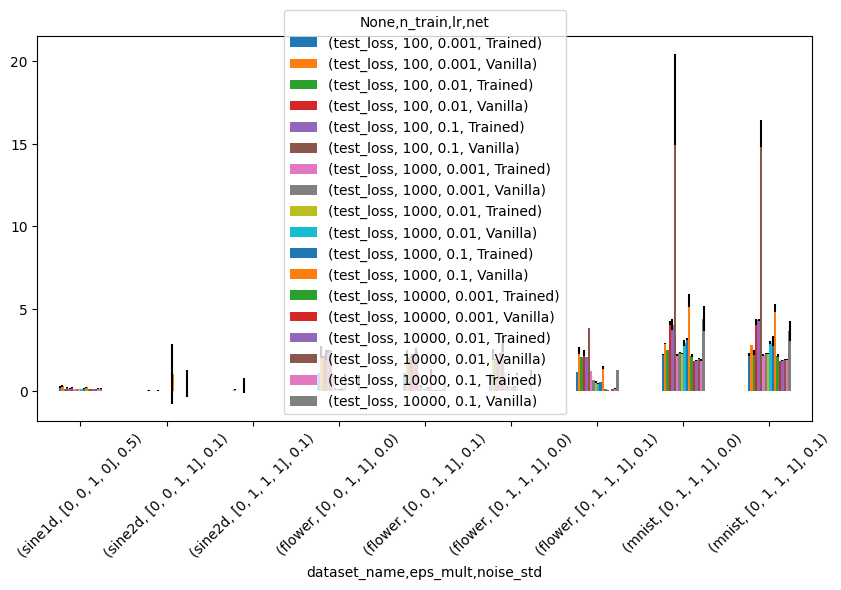

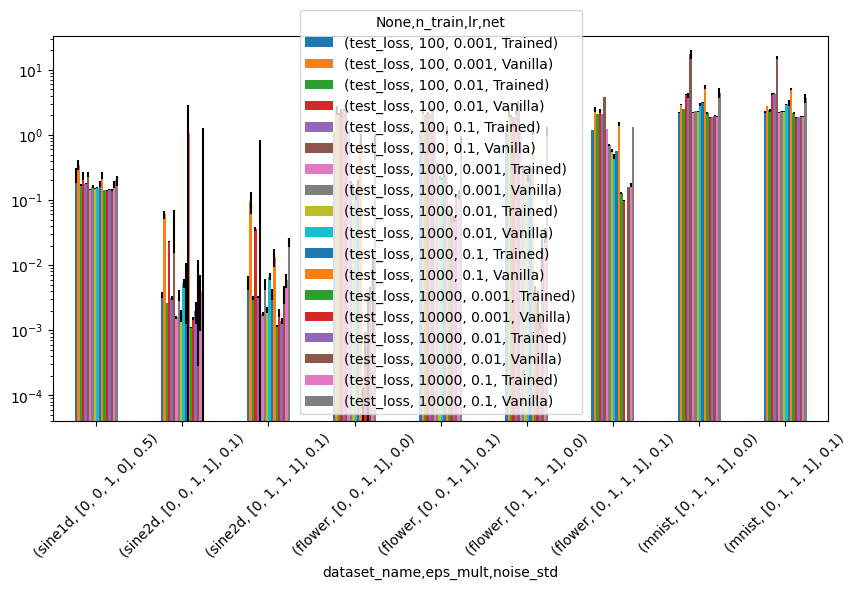

In [9]:
for logy in [False, True]:
    ddd_mean.plot(kind='bar', yerr = ddd_std, figsize = (10, 5), logy = logy, rot = 45)
    plt.show()

In [11]:
# n_plots = len(d_pivots)
# plot_dir = 'x'


# n_height, n_width = 1, n_plots if plot_dir == 'x' else n_plots, 1
# fig, axs = plt.subplots(n_plots, 1, figsize=(5*n_height, 2*n_width), tight_layout=True)

# for i, ((dataset_name, group), (d_pivot, map_kwargs)) in enumerate(d_pivots.items()):
#     ax = axs[i]

#     unstack = lambda d, metric: d.apply(metric).unstack().reset_index(level=0, drop = True)
#     d_mean, d_std = unstack(d_pivot, pd.Series.mean), unstack(d_pivot, pd.Series.std)

#     d_mean.plot(kind='barh', xerr=d_std, ax = ax, legend = False)
#     ax.set_title(f'{dataset_name} - {group}')
#     if i == 0: ax.legend(loc = 'upper center', bbox_to_anchor=(0.5, 1.5), ncol = 2)
    
#     if datasets_predict[dataset_name]['log']: ax.set_xscale('log')